# <span style="color: green">Part II – Pre-Processing

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

In [2]:
raw_data =  pd.read_csv('train.csv', header=0,  sep=',')

In [3]:
bikeDataPP = raw_data.copy()

## Scatter Matrix of weather features:

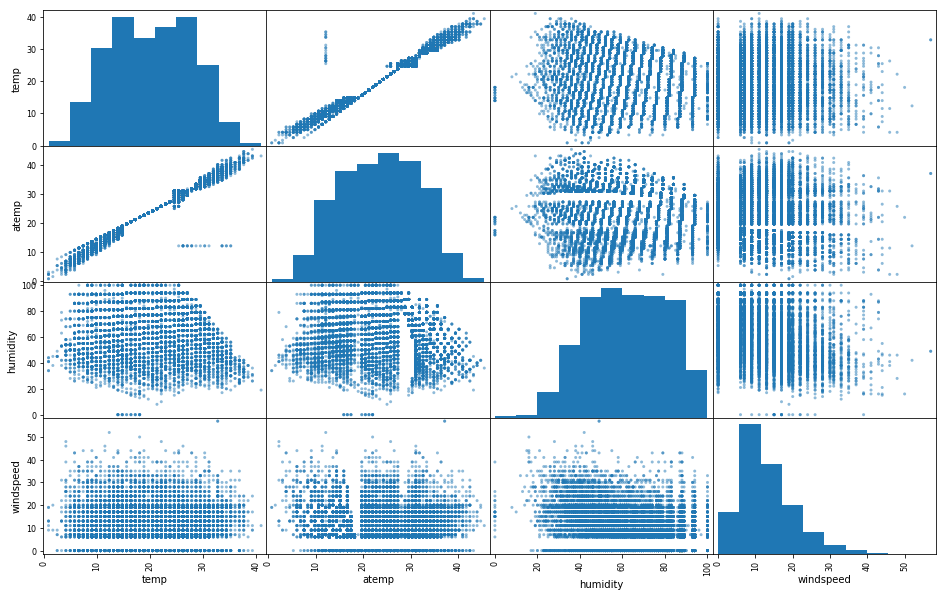

In [4]:
scatter = scatter_matrix(bikeDataPP[['temp','atemp','humidity','windspeed']], figsize=(16, 10))

### Removing outliers:

In [5]:
bikeDataPP.loc[:,'color'] = 'lavender'
# color lavender found here: https://matplotlib.org/examples/color/named_colors.html
bikeDataPP.loc[bikeDataPP.humidity < 10, 'color'] = 'black'
bikeDataPP.loc[bikeDataPP.windspeed > 45, 'color'] = 'black'
bikeDataPP.loc[(bikeDataPP.atemp < 15) & (bikeDataPP.temp > 25), 'color'] = 'black'
bikeDataPP.loc[(bikeDataPP.atemp > 44) & (bikeDataPP.humidity < 37.5),'color'] = 'black'
bikeDataPP.loc[(bikeDataPP.atemp > 42) & (bikeDataPP.humidity < 32),'color'] = 'black'
bikeDataPP.loc[(bikeDataPP.atemp < 5) & (bikeDataPP.humidity > 55),'color'] = 'black'
bikeDataPP.loc[(bikeDataPP.atemp < 2) & (bikeDataPP.humidity < 40),'color'] = 'black'
bikeDataPP.loc[(bikeDataPP.atemp < 6) & (bikeDataPP.humidity < 30),'color'] = 'black'
bikeDataPP.loc[(bikeDataPP.atemp > 25) & (bikeDataPP.humidity < 11) & (bikeDataPP.humidity > 9),'color'] = 'black'

## Scatter Matrix of weather features showing outliers:

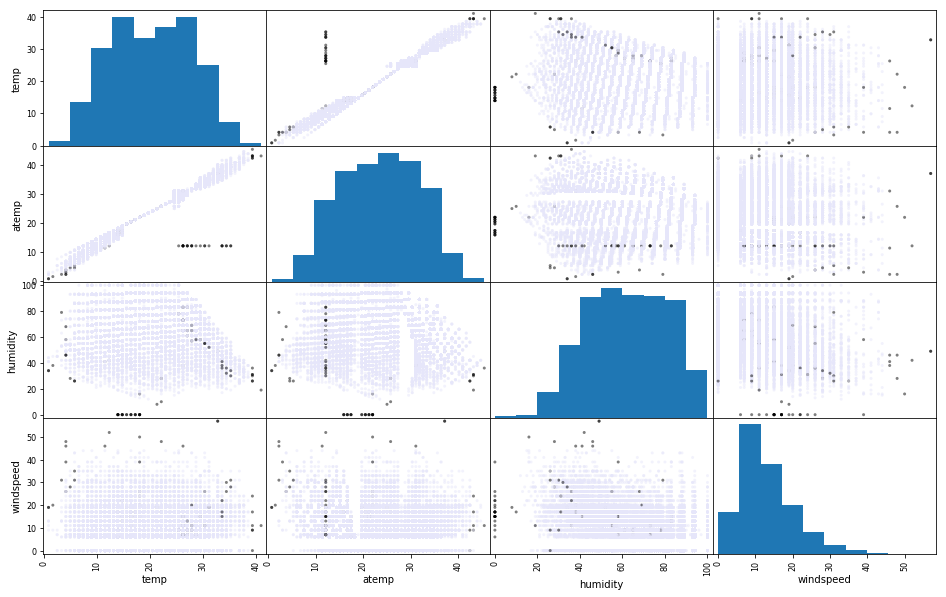

In [6]:
scatter = scatter_matrix(bikeDataPP[['temp','atemp','humidity','windspeed']], figsize=(16, 10), color = bikeDataPP['color'])

In [7]:
bikeDataPP.drop(bikeDataPP[bikeDataPP.color == 'black'].index, inplace=True)

In [8]:
bikeDataPP.drop('color', axis=1, inplace=True)

## Scatter Matrix of weather features after removing outliers:

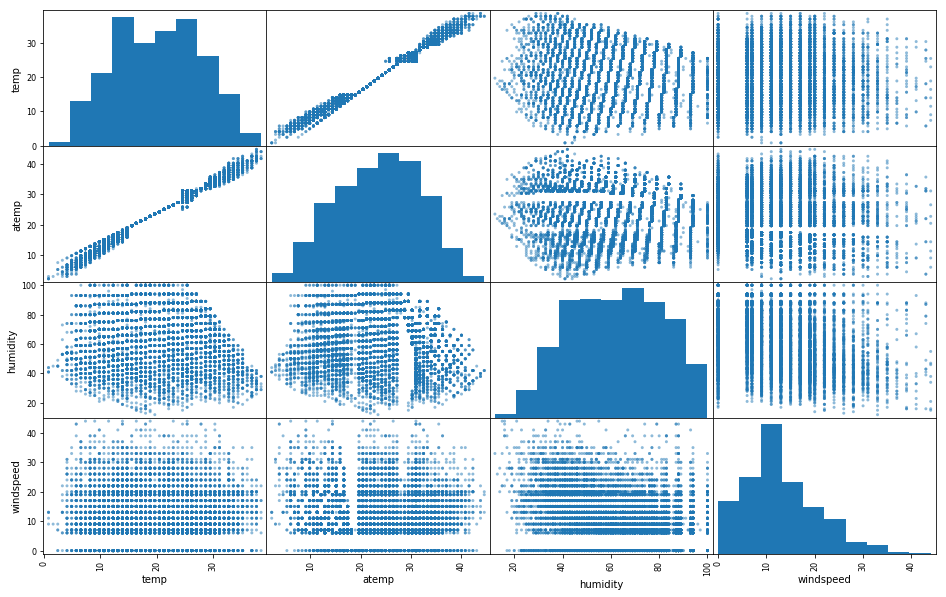

In [9]:
scatter = scatter_matrix(bikeDataPP[['temp','atemp','humidity','windspeed']], figsize=(16, 10))

## <U>Custom transformers:</U>

### Column Renamer Transformer

In [10]:
class Column_Renamer(BaseEstimator, TransformerMixin):
    def __init__(self, colname, new_name):
        self.colname = colname
        self.new_name = new_name
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):    
        X_copy = X.copy()
        X_copy.rename(columns={self.colname:self.new_name}, inplace=True)
        return X_copy

In [11]:
count_to_total_column_renamer = Column_Renamer('count','total')

### Drop Column Transformer

In [12]:
class Drop_Column(BaseEstimator, TransformerMixin):
    def __init__(self, colname):
        self.colname = colname
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):    
        X_copy = X.copy()
        X_copy.drop(self.colname, axis=1, inplace=True)
        return X_copy

In [13]:
drop_atemp_column_transformer = Drop_Column('temp')

### Binned Data Digitizer Transformer

In [14]:
class Digitizer(BaseEstimator, TransformerMixin):
    def __init__(self, colname, bins):
        self.colname = colname
        self.bins = bins
    def fit(self, X, y=None):
        self.labels = ['{}-{}'.format(low, high) for low, high in zip(self.bins[:-1], self.bins[1:])]        
        return self
    def transform(self, X, y=None):    
        X_copy = X.copy()
        binned = pd.cut(X_copy[self.colname], 
                        bins=self.bins, 
                        labels=self.labels, 
                        include_lowest=True)
        X_copy[self.colname] = binned.astype(str)
        return X_copy

In [15]:
windspeed_digitizer_transformer = Digitizer('windspeed', [0, 10, 20, 30, 45])

### Add custom detail date related columns transformer

In [16]:
def add_detail_date_columns(df):
    df['datetime'] = pd.DatetimeIndex(df.datetime)
    df['month'] = df['datetime'].apply(lambda x:x.month)
    df['hour'] = df['datetime'].apply(lambda x:x.hour)
    df['weekday'] = df['datetime'].apply(lambda x:x.dayofweek)  # 0 is Mon,1 is Tue etc...
    df['peakhours'] = df['datetime'].apply(lambda x:int(x.hour in [8,17,18]))    
    df['isweekend'] = df['weekday'].apply(lambda x:int(x in [5,6]))
    return df
    
add_detail_date_columns_transformer = FunctionTransformer(func=add_detail_date_columns, validate=False)

### Categorical data binarizer transformers

In [17]:
class Binarizer(BaseEstimator, TransformerMixin):
    def __init__(self, colname, drop_first):
        self.colname = colname
        self.drop_first = drop_first
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dummies = pd.get_dummies(X[self.colname], 
                                 prefix=self.colname, 
                                 columns=[self.colname], 
                                 drop_first=self.drop_first)
        X_no_col = X.drop(self.colname, axis=1, inplace=False)
        X_with_dummies = X_no_col.join(dummies)
        return X_with_dummies

In [18]:
windspeed_binarizer_transformer = Binarizer(colname='windspeed', drop_first=False)
season_binarizer_transformer = Binarizer(colname='season', drop_first=False)
weather_binarizer_transformer = Binarizer(colname='weather', drop_first=False)
month_binarizer_transformer = Binarizer(colname='month', drop_first=False)
hour_binarizer_transformer = Binarizer(colname='hour', drop_first=False)
weekday_binarizer_transformer = Binarizer(colname='weekday', drop_first=False)

### Standard Scaler Transformer

In [19]:
class Standard_Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, colnames):
        self.colnames = colnames
    def fit(self, X, y=None):
        self.scaler = StandardScaler().fit(X.loc[:,self.colnames])
        return self
    def transform(self, X, y=None):    
        X_copy = X.copy()
        X_copy.loc[:,self.colnames] = self.scaler.transform(X_copy.loc[:,self.colnames])
        return X_copy

In [20]:
standard_scaler_transformer = Standard_Scaler(['atemp','humidity'])

# Pipeline:

In [21]:
steps = [('count_to_total_column_renamer', count_to_total_column_renamer),
         ('drop_atemp_column_transformer', drop_atemp_column_transformer),
         ('add_detail_date_columns_transformer', add_detail_date_columns_transformer),
         ('windspeed_digitizer_transformer', windspeed_digitizer_transformer),
         ('windspeed_binarizer_transformer', windspeed_binarizer_transformer),
         ('season_binarizer_transformer', season_binarizer_transformer),
         ('weather_binarizer_transformer', weather_binarizer_transformer),
         ('month_binarizer_transformer', month_binarizer_transformer),
         ('hour_binarizer_transformer', hour_binarizer_transformer),
         ('weekday_binarizer_transformer', weekday_binarizer_transformer),
         ('standard_scaler_transformer', standard_scaler_transformer)]

transformers_pipeline = Pipeline(steps)

In [22]:
bikeDataPP = transformers_pipeline.fit_transform(bikeDataPP)

In [23]:
bikeDataPP.head()

,datetime,holiday,workingday,atemp,humidity,casual,registered,total,peakhours,isweekend,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01 00:00:00,0,0,-1.102435,0.993927,3,13,16,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2011-01-01 01:00:00,0,0,-1.192510,0.941370,8,32,40,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2011-01-01 02:00:00,0,0,-1.192510,0.941370,5,27,32,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2011-01-01 03:00:00,0,0,-1.102435,0.678586,3,10,13,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2011-01-01 04:00:00,0,0,-1.102435,0.678586,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [24]:
# bikeDataPP.info()

## Testing Standard Scaler without pipeline:

In [25]:
raw_data_ss_test =  pd.read_csv('train.csv', header=0,  sep=',')
raw_data_ss_test = raw_data_ss_test[['atemp','humidity']]
raw_data_ss_test.head()

,atemp,humidity
0,14.395,81
1,13.635,80
2,13.635,80
3,14.395,75
4,14.395,75


In [26]:
raw_data_ss_test = pd.DataFrame(StandardScaler().fit_transform(raw_data_ss_test), columns=['atemp','humidity'])
raw_data_ss_test.head()

,atemp,humidity
0,-1.092737,0.993213
1,-1.182421,0.941249
2,-1.182421,0.941249
3,-1.092737,0.681430
4,-1.092737,0.681430
